In [1]:
# Loading libraries for the course
from skimage import io as ski_io
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
import skimage as ski
from matplotlib import animation            # Module to plot animations
from skimage.filters import difference_of_gaussians
from skimage import io, measure               # Module from skimage
from cellpose import models

# Cell image analysis code created by DRUG_E team:
# Eli, Pegah, Kristi and Daria.

# Cytoplasm

In [2]:
# Load the image
figName = './Drug2_1000nM/rep1_FOV1.tif'
img = ski_io.imread(figName)

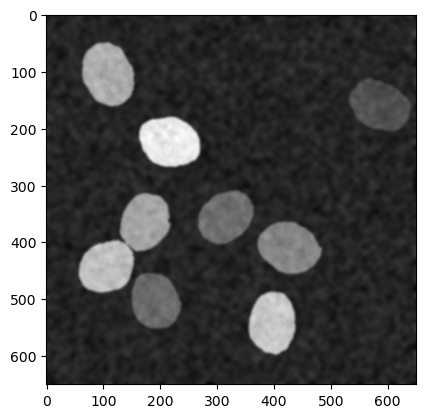

In [3]:
# Select the appropriate frame and color channel
selected_frame = 4
selected_color_channel = 1
img_to_analyze = img[selected_frame, :, :, selected_color_channel]
plt.imshow(img_to_analyze, cmap='gray')
plt.show()

In [4]:
# Initialize Cellpose model for cytoplasm detection
model_cyto = models.Cellpose(gpu=False, model_type='cyto')
masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

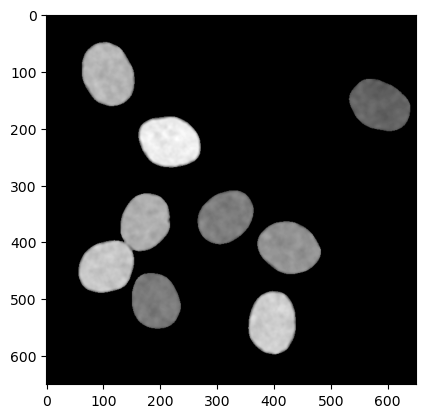

In [5]:
# Apply the cytoplasm mask to the original image
img_bin_cyto = img_to_analyze * (masks_cyto > 0.5)

# Plotting the masked cytoplasm image
plt.imshow(img_bin_cyto, cmap='gray')
plt.show()

In [6]:
# Prepare data for the cytoplasm DataFrame
data_cyto = []
for cell_id in np.unique(masks_cyto):
    if cell_id == 0:
        continue  # skip the background

    mask = masks_cyto == cell_id
    sum_pix_intensity = img_to_analyze[mask].sum()
    cell_sizes = np.sum(mask)

    data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])
print(df_cyto)

   time  cell_ID  sum_pix_intensity_cyto  cell sizes
0     4        1                  940770        8167
1     4        2                  479678        7425
2     4        3                 1162659        7859
3     4        4                  574549        7092
4     4        5                  776694        6984
5     4        6                  736931        7816
6     4        7                  908015        7237
7     4        8                  534028        6718
8     4        9                  960991        7461


# Nucleus

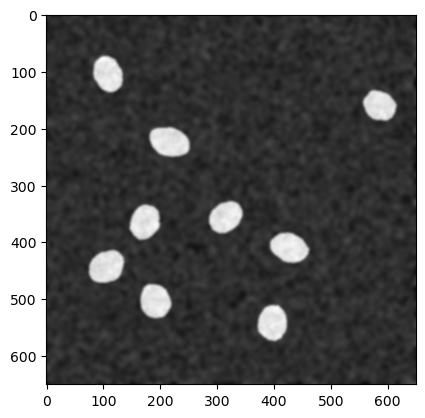

In [7]:
# Select the appropriate frame and color channel
selected_frame = 4
selected_color_channel = 0
img_to_analyze = img[selected_frame, :, :, selected_color_channel]
plt.imshow(img_to_analyze, cmap='gray')
plt.show()

In [8]:
# Initialize Cellpose model for cytoplasm detection
model_nuc = models.Cellpose(gpu=False, model_type='nuclei')
masks_nuc, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

# Associating each nucleus with its corresponding cytosol
nucleus_indices = np.zeros(np.max(masks_cyto)+1)
for i in range(1,np.max(masks_nuc)+1):
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

print(nucleus_indices)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


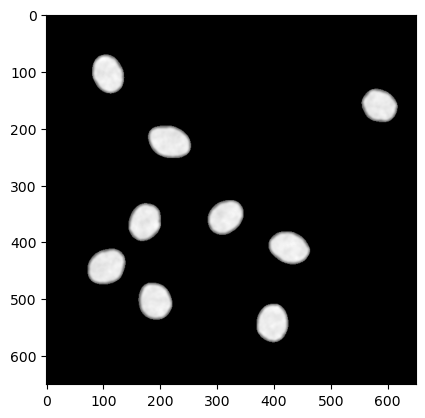

In [9]:
# Apply the cytoplasm mask to the original image
img_bin_nuc = img_to_analyze * (masks_nuc > 0.5)

# Plotting the masked cytoplasm image
plt.imshow(img_bin_nuc, cmap='gray')
plt.show()

In [10]:
# Prepare data for the nucleus DataFrame
data_nuc = []
for cell_id in np.unique(masks_nuc):
    if cell_id == 0:
        continue  # skip the background

    mask = masks_nuc == cell_id
    sum_pix_intensity = img_to_analyze[mask].sum()
    cell_sizes = np.sum(mask)

    data_nuc.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

df_nuc = pd.DataFrame(data_nuc, columns=['time', 'cell_ID', 'sum_pix_intensity_nucleus', 'cell sizes'])
print(df_nuc)

   time  cell_ID  sum_pix_intensity_nucleus  cell sizes
0     4        1                     463780        3024
1     4        2                     431099        2886
2     4        3                     525242        3454
3     4        4                     455995        3012
4     4        5                     457902        3033
5     4        6                     492930        3224
6     4        7                     506745        3373
7     4        8                     468725        3104
8     4        9                     468055        3033


# mRNA


Example of mRNA detection in images using watershed and cellpose methods.

In [11]:
# Selecting the color channel with RNA spots
selected_frame = 4
selected_color_channel = 2
img_to_analyze = img[selected_frame, :, :, selected_color_channel]

In [12]:
# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_to_analyze,low_sigma=1, high_sigma=5)

C:\Users\daria\AppData\Local\Temp\ipykernel_30468\4096356421.py:17: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


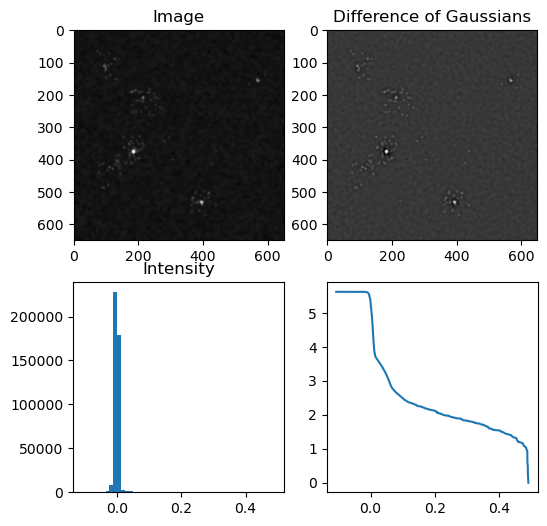

intensity range:  -0.10701930218472178 0.49039385402837565


In [13]:
# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_to_analyze,cmap='Greys_r')
ax[0,0].set(title='Image')

# Show image after Gaus
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Show a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Show a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

# Print intensity range
plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

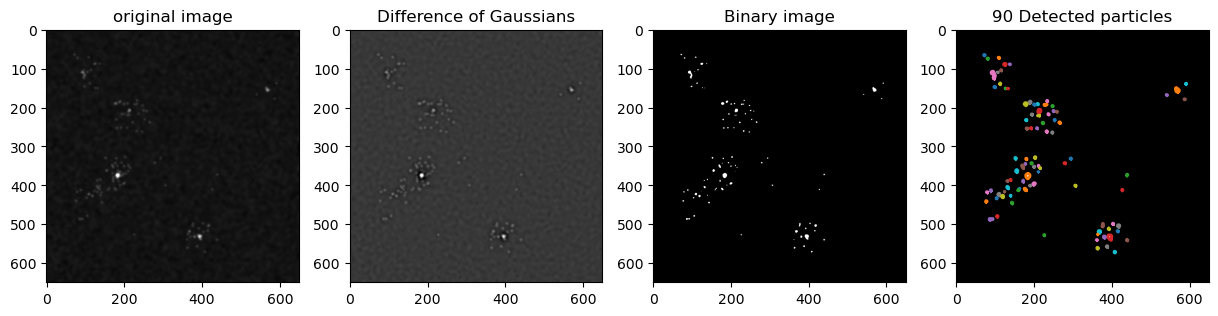

In [14]:

# Show original image in MS2 channel
fig, ax = plt.subplots(1,4, figsize=(15, 6))
ax[0].imshow(img_to_analyze,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_spots_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
threshold = 0.05
img_spots_binary = img_spots_filtered.copy()
img_spots_binary[img_spots_binary>=threshold] = threshold # Making spots above the threshold equal to the threshold value.
img_spots_binary[img_spots_binary<threshold] = 0 # Making spots below the threshold equal to 0.
ax[2].imshow(img_spots_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_spots_binary[img_spots_binary!=0] = 1 # Binarization
ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
spot_contours = measure.find_contours(img_spots_binary, 0.5)
for contour in spot_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(spot_contours))+' Detected particles' )
plt.show()





In [15]:
number_detected_cells = np.max(masks_cyto)
list_cytosol_particles = np.zeros(number_detected_cells)
list_nuclear_particles = np.zeros(number_detected_cells)

# Let' compute the mean intensity for each cell in the image.
list_mean_intensities = []
img_cyto = img[10,:,:,0:3]
for iMask in range (1,number_detected_cells+1):
  selected_mask = masks_cyto==iMask
  mean_intensity = []
  for iColor in range(3):
    selected_color_image = selected_mask*img_cyto[:,:,iColor]
    mean_intensity.append(selected_color_image[np.nonzero(selected_color_image)].mean())
  list_mean_intensities.append(mean_intensity)


In [16]:
# Convert the list to a pandas dataframe and display
df = pd.DataFrame(list_mean_intensities, columns=['Ch0', 'Ch1', 'Ch2'])

# Loop through the cytosol masks
for i in range(len(spot_contours)):
    # Find the position of the particle
    posn = np.mean(spot_contours[i], axis=0).astype(int)

    # Check which cyto mask is the particle in
    cell_num = masks_cyto[posn[0], posn[1]]
    if cell_num>0:
        list_cytosol_particles[cell_num-1] += 1

        # Check if the particle is also in the nucleus
        if masks_nuc[posn[0], posn[1]] == nucleus_indices[cell_num]:
            list_nuclear_particles[cell_num-1] += 1

# Add the number of particles to the dataframe
df['Particles in cytosol'] = list_cytosol_particles
df['Particles in nucleus'] = list_nuclear_particles
df

,Ch0,Ch1,Ch2,Particles in cytosol,Particles in nucleus
0,69.497123,40.413004,29.884046,12.0,6.0
1,100.767542,65.857104,33.575354,4.0,3.0
2,106.076600,98.694490,32.878992,22.0,6.0
3,104.078680,68.520587,33.838973,3.0,0.0
4,105.901346,98.248139,37.862829,19.0,7.0
5,104.548106,67.071392,30.573311,2.0,1.0
6,70.092027,39.745751,30.442725,12.0,5.0
7,108.201995,67.479160,36.346532,1.0,0.0
8,103.968905,89.991422,30.162713,13.0,6.0


# Statistic

Loading Data- We are using data from Dr. Munsky because our code to extract this information is taking a long time to run and we decided to borrow the data.

In [17]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.pyplot as plt
import numpy.random as rng
import scipy.stats as stats
# Uncomment the following the first time if you do not have seaborn installed:
#!pip install seaborn
import seaborn as sns
from typing import Union # for code annotation

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data from CSV in file.
Drug2_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug2_1000nM_DesignResults.csv')
Drug6_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug6_1000nM_DesignResults.csv')
Drug7_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug7_1000nM_DesignResults.csv')

No_Drug = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\NoDrug_DesignResults.csv')


## Comparison of the effects of antibiotics on cells. Number of mRNA molecules in the nucleus, number of mRNA molecules in the cytoplasm, protein concentration and vitality.

Our task was to describe the mode of action of one drug. To do this, we had to compare the drugs with each other. Drug 2 with a concentration of 1000nM, Drug 6 with the same concentration and Drug 7. To do this, we presented graphs with the mean value and standard deviation in time.

After administration of Drug 2, we observe the following changes in cellular parameters:

Nuclear mRNA count (num_rna_nuc): Nuclear mRNA count begins to increase, suggesting increased mRNA production or stopped transport from nucleus to the cytoplasm.
Cytoplasmic mRNA count (num_rna_cyto): The cytoplasmic mRNA count is decreasing, which may indicate decreased mRNA transport from the nucleus to the cytoplasm.
Protein concentration (Cyto_Intensity_1): Protein concentration in the cytoplasm decreases, consistent with a decrease in the number of mRNAs in the cytoplasm, suggesting reduced protein translation.
Cell Vitality (is_cell_vital): Cell vitality decreases over time, indicating the cytotoxic effects of Drug 2 and gradual cell death.

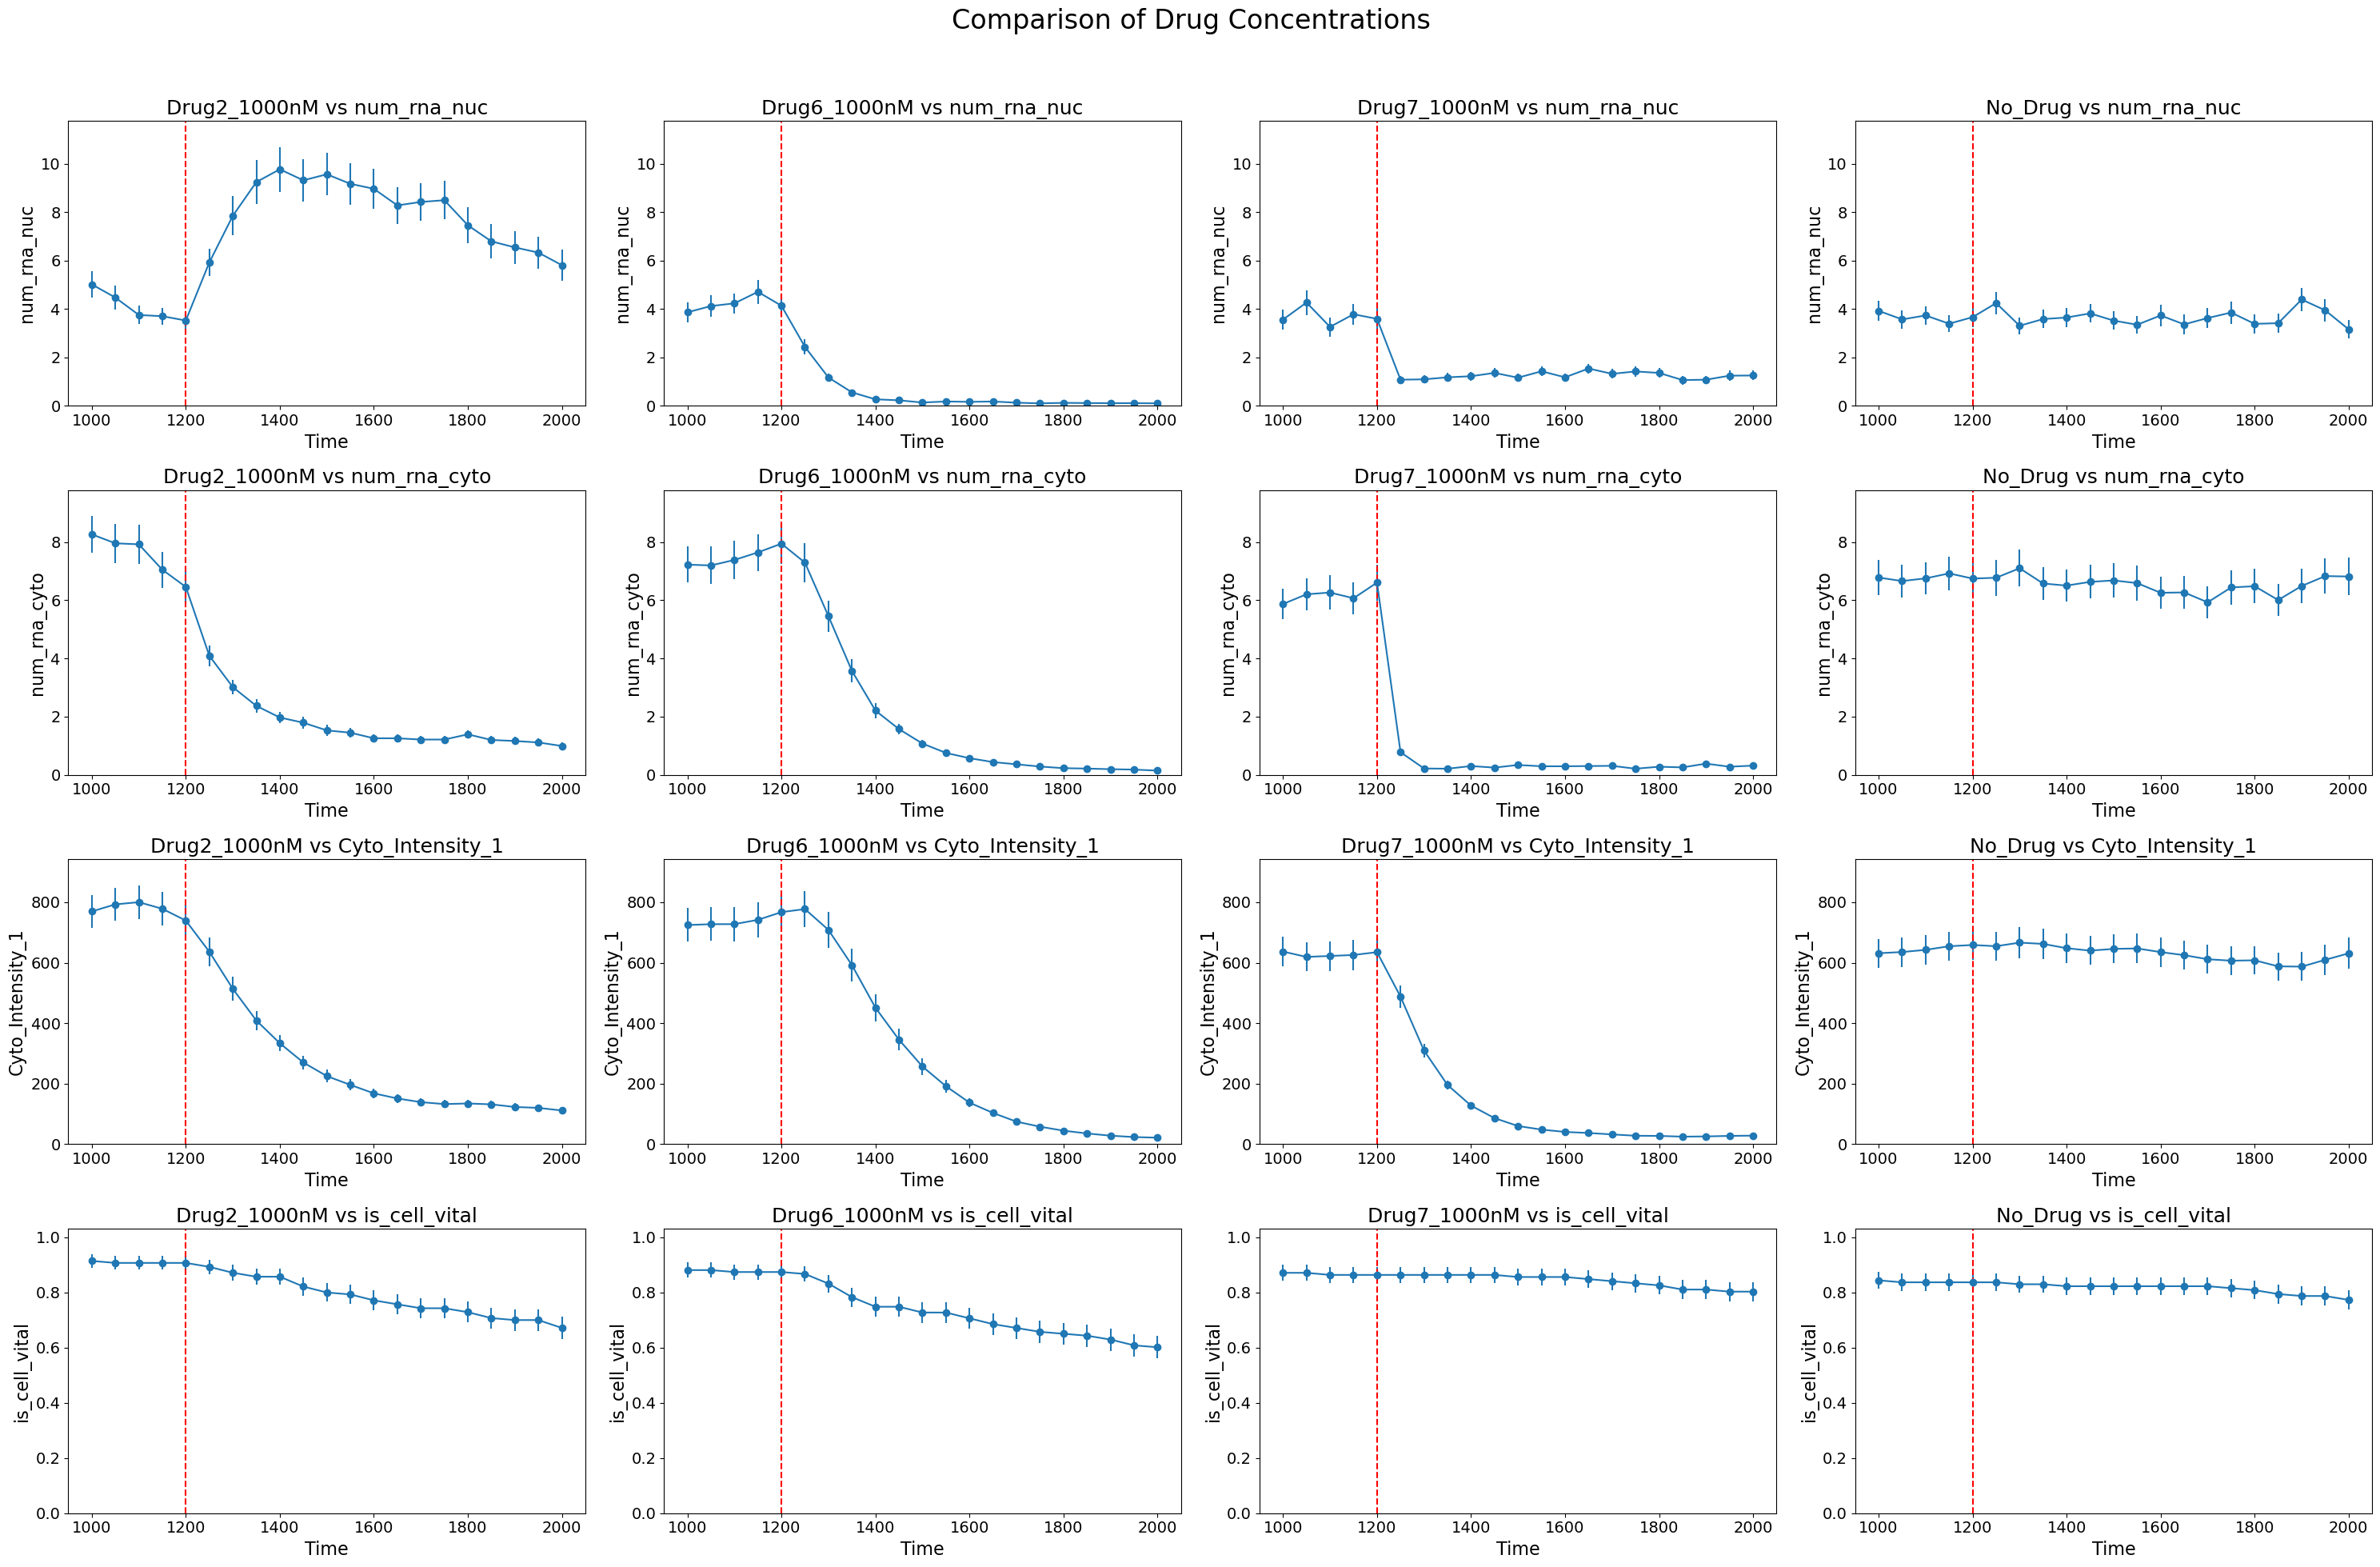

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List of drug names (assuming drugs are arranged in order across 11 columns)
drug_names = ['Drug2_1000nM', 'Drug6_1000nM', 'Drug7_1000nM', 'No_Drug']

# List of y labels for each row
y_labels = ['num_rna_nuc', 'num_rna_cyto', 'Cyto_Intensity_1', 'is_cell_vital']

# Set the font size globally
plt.rcParams.update({'font.size': 14})

# Calculate global min and max for each y_label across all drugs
global_mins = {}
global_maxs = {}

for y_label in y_labels:
    global_min = np.inf
    global_max = -np.inf
    for drug in drug_names:
        drug_data = eval(drug)
        grouped = drug_data.groupby('Time')[y_label]
        means = grouped.mean()
        sems = grouped.sem()
        global_min = min(global_min, np.nanmin(means - sems))
        global_max = max(global_max, np.nanmax(means + sems))
    global_mins[y_label] = global_min
    global_maxs[y_label] = global_max

fig, axs = plt.subplots(len(y_labels), len(drug_names), figsize=(30, 20))
fig.suptitle('Comparison of Drug Concentrations', fontsize=24)

for i, drug in enumerate(drug_names):
    drug_data = eval(drug)
    for j, y_label in enumerate(y_labels):
        # Group by 'Time' and calculate mean and SEM
        grouped = drug_data.groupby('Time')[y_label]
        means = grouped.mean()
        sems = grouped.sem()

        times = means.index

        # Plot with error bars
        axs[j, i].errorbar(times, means, yerr=sems, fmt='-o')
        axs[j, i].axvline(x=1200, color='r', linestyle='--')  # Add vertical line at Time = 1200
        axs[j, i].set_title(f'{drug} vs {y_label}', fontsize=18)
        axs[j, i].set_xlabel('Time', fontsize=16)
        axs[j, i].set_ylabel(y_label, fontsize=16)
        axs[j, i].set_ylim([0, 1.1 * global_maxs[y_label]])  # Use global max for y-axis limit
        axs[j, i].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make room for the title
plt.show()


## Based on the charts, we were to create action patterns for these drugs. We present them in the images below.

Drug 2 mechanism of action:

<img src="Drug_2_diagram.jpg" alt="Drug_2_diagram.jpg" width="800"/>

Drug 6 mechanism of action:

<img src="Obraz6_diagram.png" alt="Obraz6_diagram.png" width="800"/>


Drug 7 mechanism of action:

<img src="Drug_7 diagram.jpg" alt="Drug_7 diagram.jpg" width="800"/>


# Model for 1000 nM only

In [204]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from types import *
import matplotlib.animation as animation
from matplotlib import rc
import pandas as pd

rc('animation', html='jshtml')
figSize=600

# Let's define a simple function that computes the time of the next reaction given our propensity functions:
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Let's define a simple function that computes the index of the next reaction given our propensity functions:
def next_reaction(x, t, W, pars, di, ti):
    W = W(x, t, pars=pars)
    W0 = np.sum(W)
    r = np.random.rand()
    i = 0
    W_sum = W[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:

        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars, di, ti)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        # Return the full trajectory
        return np.array(times), np.array(states)
    else:
        # Return only the final state
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti, drug_number)).flatten()
    return y


def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):

    if model == 'ODE':
        trajectory = odeint(dxdt,np.array(x0),t, args=(pars, di, ti))

    if model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times,states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            
            k = 0
            for j in range(len(times)):
                while times[j] > t[k]:
                    trajectory[i,k,:] = states[j]
                    k+=1

        trajectory = np.mean(trajectory, axis=0)
    return trajectory


def compare_model_to_data(pars,di,ti, x0, drug_number, drug_conc,speciesDict, path='.', model='ODE', ntraj=10):
    #
    # example_df = pd.read_csv(r'C:\Users\wsraymon\Desktop\uqbio2024_challenge_solns\Data\Drug1_3000nM_DesignResults.csv')
    if drug_number == 0:
        example_df = pd.read_csv(path + '/NoDrug_DesignResults.csv' )
    else:
        example_df = pd.read_csv(path + '/Drug%i_%inM_DesignResults.csv'%(drug_number,drug_conc) )
    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros([5,len(t)])
    data_std = np.zeros([5,len(t)])
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1,k] = np.mean(subdf['num_rna_nascent'])
        data[2,k] = np.mean(subdf['num_rna_nuc'])
        data[3,k] = np.mean(subdf['num_rna_cyto'])
        data[4,k] = np.mean(subdf['Cyto_Intensity_1'])

        data_std[1,k] = np.std(subdf['num_rna_nascent'])/np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2,k] = np.std(subdf['num_rna_nuc'])/np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3,k] = np.std(subdf['num_rna_cyto'])/np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4,k] = np.std(subdf['Cyto_Intensity_1'])/np.sqrt(len(subdf['Cyto_Intensity_1']))
        k+=1

    fig,ax = plt.subplots(1,4, tight_layout=True, figsize=(10,4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0,2000,2001),pars, di, ti, model=model, ntraj=ntraj )

    ax[0].plot(np.linspace(0,2000,2001), s.T[speciesDict['Nascent']], )
    ax[1].plot(np.linspace(0,2000,2001), s.T[speciesDict['Nuclear']],)
    ax[2].plot(np.linspace(0,2000,2001), s.T[speciesDict['Cytoplasmic']],)
    ax[3].plot(np.linspace(0,2000,2001), s.T[speciesDict['Protein']],)

    ax[0].set_xlim([1000,2000])
    ax[1].set_xlim([1000,2000])
    ax[2].set_xlim([1000,2000])
    ax[3].set_xlim([1000,2000])

In [268]:
# Stoichiometry matrix
S = np.array([
    [-1, 1, 0, 0, 0, 0, 0, 0, 0, 0], # DNA_OFF to DNA_ON
    [1, -1, 0, 0, 0, 0, 0, 0, 0, 0], # DNA_ON to DNA_OFF
    [0, 0, 1, -1, -1, 0, 0, 0, 0, 0], # RNA_Nascent to RNA_Nuclear 
    [0, 0, 0, 0, 1, -1, -1, 0, 0, 0], # RNA_Nuclear to RNA_Cytoplasmic
    [0, 0, 0, 0, 0, 0, 1, -1, -1, 0], # RNA_Cytoplasmic to Protein
    [0, 0, 0, 0, 0, 0, 0, 0, 1, -1]  # Protein to Degradation 
    ])

ti = [np.inf,1200,np.inf]

x0 = np.array([1,0,6.2,4.5,8,1000])


#params for the model 
pars = {'k0': 10000,  # DNA_OFF to DNA_ON
        'k1': 1,  # DNA_ON to DNA_OFF
        'k2': 1400,  # DNA_ON to RNA_Nascent
        'k3': 20,  # RNA_Nascent denature
        'k4': 180, # RNA_Nascent to RNA_Nuclear
        'k5': 60, # RNA_Nuclear denture
        'k6': 220,  # RNA_Nuclear to RNA_Cytoplasmic
        'k7': 21, # RNA_Cytoplasmic denature was 10
        'k8': 100,  # RNA_Cytoplasmic to Protein
        'k9': 1.08} # Protein to Degradation 


speciesDict = {'Nascent':2, 'Nuclear':3, 'Cytoplasmic':4, 'Protein':5}  # how to map your species to the data 


import numpy as np


# Funkcja Hilla
def hill_function(concentration, Kd, n):
    if concentration == 0:
        return 0
    else:
        return concentration**n / (Kd**n + concentration**n)

# Funkcja obliczająca wartości W
def W(x, t, pars, di, ti, drug_number):

    di= di

    k0 = pars['k0']
    k1 = pars['k1']
    k2 = pars['k2']
    k3 = pars['k3']
    k4 = pars['k4']
    k5 = pars['k5']
    k6 = pars['k6']
    k7 = pars['k7']
    k8 = pars['k8']
    k9 = pars['k9']

    W = np.array([
            k0 * x[0] * ( t < ti[1]) + hill_function(di[0], 0.5, -0.5)* ( t >= ti[1]),  # DNA_OFF to DNA_ON
            k1 * x[1] * ( t < ti[1]) + hill_function(di[1], 0.5, -0.5)* ( t >= ti[1]),  # DNA_ON to DNA_OFF
            k2 * x[1] * ( t < ti[1]) + hill_function(di[2], 0.5, -0.5)* ( t >= ti[1]),  # DNA_ON to RNA_Nascent
            k3 * x[2] * ( t < ti[1]) + hill_function(di[3], 1000, 10)* ( t >= ti[1]),  # RNA_Nascent denature
            k4 * x[2] * ( t < ti[1]) + hill_function(di[4], 0.5, -0.5)* ( t >= ti[1]),  # RNA_Nascent to RNA_Nuclear
            k5 * x[3] * ( t < ti[1]) + hill_function(di[5], 0.5, -0.5)* ( t >= ti[1]),  # RNA_Nuclear denture
            k6 * x[3] * ( t < ti[1]) + hill_function(di[6], 0.5, -0.5)* ( t >= ti[1]),  # RNA_Nuclear to RNA_Cytoplasmic
            k7 * x[4] * ( t < ti[1]) + hill_function(di[7], 0.5, -0.5)* ( t >= ti[1]),  # RNA_Cytoplasmic denature
            k8 * x[4] * ( t < ti[1]) + hill_function(di[8], 0.5, -0.5)* ( t >= ti[1]),  # RNA_Cytoplasmic to Protein
            k9 * x[5] * ( t < ti[1]) + hill_function(di[9], 1000, 5)* ( t >= ti[1])   # Protein to Degradation
        ])
       
    return W



 We have a problem with setting the k6 parameter, switching from mRNA_nuc to mRNA_cyto.

Drug 0
Drug 10
Drug 10
Drug 10
Drug 10


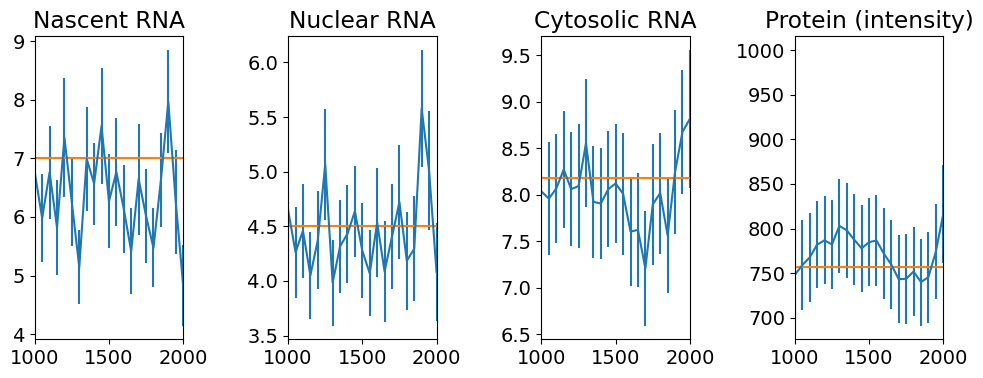

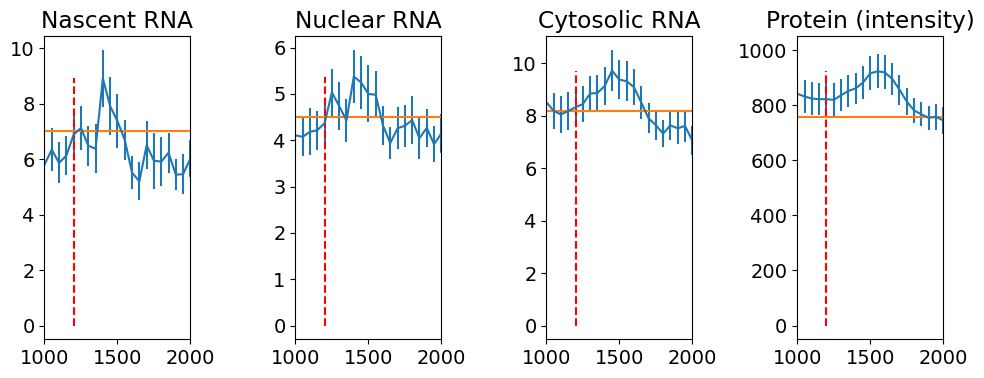

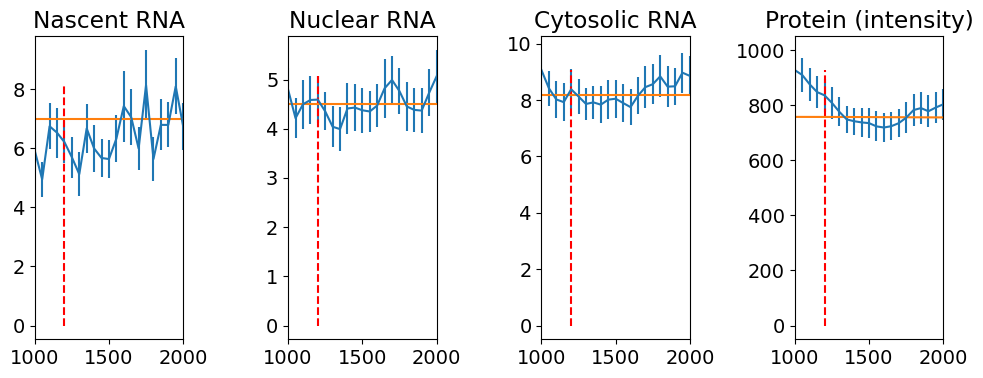

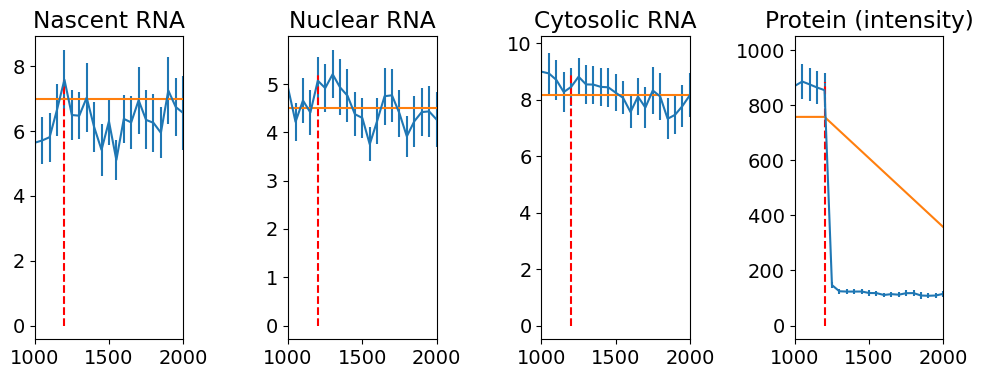

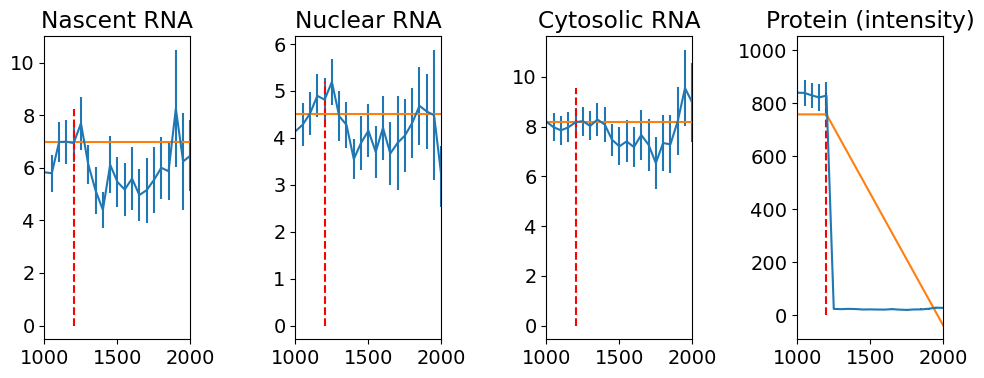

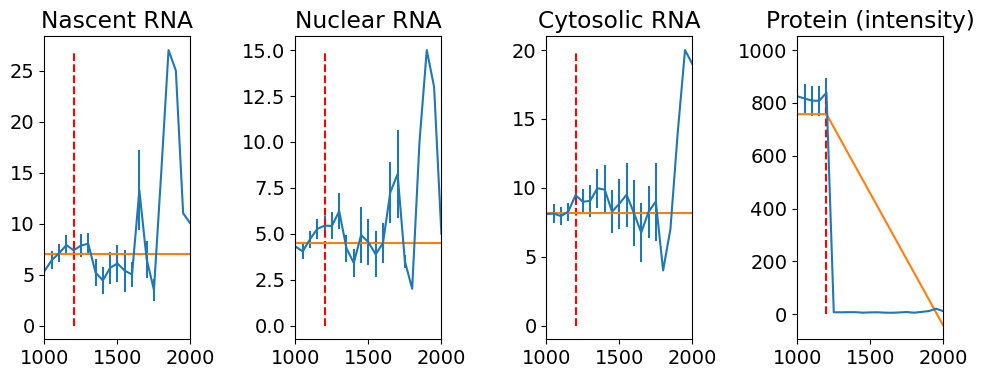

In [270]:
pathName = 'C:\\Users\\daria\\OneDrive - Politechnika Śląska\\QBio\\CourseMaterials\\uqbio2024\\UQbio2024_Team6\\TrueData'
print('Drug 0')

di=[0,0,0,0,0,0,0,0,0,0]
ti=[np.inf,1200,np.inf]
drug_conc=1000

drug_number = 0 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number, 100,speciesDict, path=pathName,
                    model='ODE',ntraj=10)


di=[0,0,0,0,0,0,0,0,0,100]
ti=[np.inf,1200,np.inf]

drug_number = 10 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number, 100,speciesDict, path=pathName,
                    model='ODE',ntraj=10)

di=[0,0, 0,0,0,0,0,0,0,300]
print('Drug 10')
drug_number = 10 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number,300, speciesDict,  path=pathName,
                    model='ODE',ntraj=10)

di=[0,0,0,0,0,0,0,0,0,1000]
print('Drug 10')
drug_number = 10 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number,1000, speciesDict,  path=pathName,
                    model='ODE',ntraj=10)

di=[0,0,0,0,0,0,0,0,0,3000]
print('Drug 10')
drug_number = 10 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number,3000, speciesDict,  path=pathName,
                    model='ODE',ntraj=10)

di=[0,0,0,0,0,0,0,0,0,10000]
print('Drug 10')
drug_number = 10 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number,10000, speciesDict,  path=pathName,
                    model='ODE',ntraj=10)



Checking the model

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
file_paths = {
    'Drug2_100nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug2_100nM_DesignResults.csv',
    'Drug2_300nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug2_300nM_DesignResults.csv',
    'Drug2_1000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug2_1000nM_DesignResults.csv',
    'Drug2_3000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug2_3000nM_DesignResults.csv',
    'Drug2_10000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug2_10000nM_DesignResults.csv',
    'Drug4_100nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug4_100nM_DesignResults.csv',
    'Drug4_300nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug4_300nM_DesignResults.csv',
    'Drug4_1000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug4_1000nM_DesignResults.csv',
    'Drug4_3000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug4_3000nM_DesignResults.csv',
    'Drug4_10000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug4_10000nM_DesignResults.csv',
    'Drug6_100nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug6_100nM_DesignResults.csv',
    'Drug6_300nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug6_300nM_DesignResults.csv',
    'Drug6_1000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug6_1000nM_DesignResults.csv',
    'Drug6_3000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug6_3000nM_DesignResults.csv',
    'Drug6_10000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug6_10000nM_DesignResults.csv',
    'Drug7_100nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug7_100nM_DesignResults.csv',
    'Drug7_300nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug7_300nM_DesignResults.csv',
    'Drug7_1000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug7_1000nM_DesignResults.csv',
    'Drug7_3000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug7_3000nM_DesignResults.csv',
    'Drug7_10000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug7_10000nM_DesignResults.csv',
    'Drug10_100nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug10_100nM_DesignResults.csv',
    'Drug10_300nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug10_300nM_DesignResults.csv',
    'Drug10_1000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug10_1000nM_DesignResults.csv',
    'Drug10_3000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug10_3000nM_DesignResults.csv',
    'Drug10_10000nM': r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug10_10000nM_DesignResults.csv',
}


# Initialize an empty list to store results
results = []

# Function to compute the required metrics for each drug
def compute_metrics(df, drug_name):
    # get concentratuion of drug from the file name
    drug_conc = int(drug_name.split('_')[-1].replace('nM', ''))
    

    # Calculate mean protein concentration at 1000 and 2000 time points
    protein_1000_time = df[df['Time'] == 1000]['Cyto_Intensity_1'].mean()
    protein_2000_time = df[df['Time'] == 2000]['Cyto_Intensity_1'].mean()
    g = (protein_1000_time - protein_2000_time) / protein_1000_time

    # Calculate mean cell vitality at 1000 and 2000 time points
    vitality_1000_time = df[df['Time'] == 1000]['is_cell_vital'].mean()
    vitality_2000_time = df[df['Time'] == 2000]['is_cell_vital'].mean()
    f = (vitality_1000_time - vitality_2000_time) / vitality_1000_time

    # Calculate J, we want know how much the drug affects the cell vitality and protein concentration
    # We looking for the biggest value of J
    # The biggest value of J means that the drug (or combination of drug) has the biggest impact on the cell vitality and protein concentration

    J = (g + f) / (1 + drug_conc) # change drug_conc for Di from concentration of used drug (if you used 2 or 3 or more)

    
    # Append results
    results.append({
        'Drug Name': drug_name,
        'Protein_1000_time': protein_1000_time,
        'Protein_2000_time': protein_2000_time,
        'g': g,
        'Vitality_1000_time': vitality_1000_time,
        'Vitality_2000_time': vitality_2000_time,
        'f': f,
        'J': J
    })

# Loop through each file, read the data, and compute metrics
for drug_name, file_path in file_paths.items():
    df = pd.read_csv(file_path)
    compute_metrics(df, drug_name)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)


         Drug Name  Protein_1000_time  Protein_2000_time         g  \
0      Drug2_100nM         725.971014         673.637681  0.072087   
1      Drug2_300nM         731.105634         626.549296  0.143011   
2     Drug2_1000nM         769.592857         111.000000  0.855768   
3     Drug2_3000nM         752.046875           3.046875  0.995949   
4    Drug2_10000nM         674.454545           0.034965  0.999948   
5      Drug4_100nM         668.000000         616.406015  0.077237   
6      Drug4_300nM         739.539568         651.244604  0.119392   
7     Drug4_1000nM         778.845070         127.035211  0.836893   
8     Drug4_3000nM         695.106061           1.007576  0.998550   
9    Drug4_10000nM         716.510791           0.000000  1.000000   
10     Drug6_100nM         757.200000         598.886667  0.209077   
11     Drug6_300nM         686.937063         380.384615  0.446260   
12    Drug6_1000nM         724.692308          20.986014  0.971041   
13    Drug6_3000nM  